In [2]:
import numpy as np
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub('<[^>]+>', ' ', text)
    text = re.sub("[^a-zA-Z]", " ", text)

    return text

In [4]:
df_train_reviews = pd.read_csv("/content/drive/MyDrive/Uni/Text Mining/2.data_detected/airbnb_df_train__reviews_detected.csv").drop("Unnamed: 0", axis=1)

In [5]:
df_train = pd.read_csv("/content/drive/MyDrive/Uni/Text Mining/2.data_detected/airbnb_df_train_detected.csv").drop("Unnamed: 0", axis=1)

In [6]:
df_train_reviews.head()

,index,comments,lang_comments
0,1,this is a very cozy and comfortable house to s...,en
1,1,good<br/>,cy
2,1,"My first hostel experience, and all I have to ...",en
3,1,Das Hostel war neu und deshalb funktionierte a...,de
4,1,"It was fine for a dorm, but I think for the pe...",en


In [7]:
df_train.head()

,index,description,host_about,unlisted,lang_desc,lang_host
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,pt,en
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,en,en
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,pt,en
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,fr,fr


In [8]:
df_merged = pd.merge(df_train,df_train_reviews, on="index", how="left")

In [9]:
del df_train
del df_train_reviews

In [10]:
df_merged.head()

,index,description,host_about,unlisted,lang_desc,lang_host,comments,lang_comments
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt,this is a very cozy and comfortable house to s...,en
1,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt,good<br/>,cy
2,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt,"My first hostel experience, and all I have to ...",en
3,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt,Das Hostel war neu und deshalb funktionierte a...,de
4,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,en,pt,"It was fine for a dorm, but I think for the pe...",en


In [11]:
def prepare_df(df):
    grouped_df = df.groupby('index').agg({
        'description': 'first',
        'host_about': 'first',
        'comments': lambda x: ' '.join(x.astype(str).values),
        'lang_comments': lambda x: ' '.join(x.astype(str).values),
        "unlisted" : "first"
    }).reset_index()

    return grouped_df

In [12]:
grouped_df = prepare_df(df_merged)

In [13]:
del df_merged

In [14]:
grouped_df.head()

,index,description,host_about,comments,lang_comments,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,this is a very cozy and comfortable house to s...,en cy en de en en en en en en en en en en fr e...,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",nan,nan,1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",nan,nan,1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,nan,nan,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,Un très bel appartement avec une magnifique vu...,fr fr es pt de de en nl en en en de en de en p...,0


In [15]:
columns_to_clean = ['description', 'host_about', 'comments']

grouped_df[columns_to_clean] = grouped_df[columns_to_clean].applymap(clean_text)

In [16]:
grouped_df.head()

,index,description,host_about,comments,lang_comments,unlisted
0,1,this is a shared mixed room in our hostel wit...,alojamento local registro al,this is a very cozy and comfortable house to s...,en cy en de en en en en en en en en en en fr e...,0
1,2,o meu espa o fica perto de parque eduardo vii ...,i am friendly host and i will try to always b...,nan,nan,1
2,3,trafaria s house is a cozy and familiar villa ...,i am a social person liking to communicate re...,nan,nan,1
3,4,apartamento charmoso no chiado entre o largo ...,hello x d i m portuguese and i love to mee...,nan,nan,0
4,5,joli appartement en bordure de mer min a...,nous sommes une famille avec deux enfants de ...,un tr s bel appartement avec une magnifique vu...,fr fr es pt de de en nl en en en de en de en p...,0


In [17]:
# Load the DataFrame
df = grouped_df.sample(800, random_state=1)

# Filter out rows with missing values in necessary columns
df = df.dropna(subset=['description', 'host_about', 'comments'])

# Extract the necessary columns
text_data = df['description'] + ' ' + df['host_about'] + ' ' + df['comments']
labels = df['unlisted']

# Split the data into train and test sets
text_train, text_test, labels_train, labels_test = train_test_split(text_data, labels, test_size=0.2, random_state=42)

# Tokenize the text and convert it into sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train)

vocab_size = len(tokenizer.word_index) + 1
max_sequence_length = max([len(sentence.split()) for sentence in text_train])

sequences_train = tokenizer.texts_to_sequences(text_train)
sequences_test = tokenizer.texts_to_sequences(text_test)

In [18]:
del grouped_df
del df
del text_data
del labels
del text_train
del text_test

In [19]:
# Pad sequences to have the same length
padded_train = pad_sequences(sequences_train, maxlen=max_sequence_length, padding='post')
padded_test = pad_sequences(sequences_test, maxlen=max_sequence_length, padding='post')

In [20]:
del sequences_train
del sequences_test

In [21]:
# Load pre-trained GloVe word embeddings
embeddings_index = {}
with open('/content/drive/MyDrive/glove.6B/glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [22]:
# Create embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [23]:
# Create word embedding feature vectors
embedded_train = np.array([embedding_matrix[word] for word in padded_train])
embedded_test = np.array([embedding_matrix[word] for word in padded_test])

In [24]:
del embedding_vector
del padded_train
del padded_test

In [25]:
embedded_train_flat = embedded_train.reshape(embedded_train.shape[0], -1)
embedded_test_flat = embedded_test.reshape(embedded_test.shape[0], -1)

In [26]:
del embedded_train
del embedded_test

In [27]:
# Train the Random Forest classifier
classifier = RandomForestClassifier(random_state=42)
classifier.fit(embedded_train_flat, labels_train)

# Predict on the test set
predictions = classifier.predict(embedded_test_flat)

# Calculate evaluation metrics
accuracy = accuracy_score(labels_test, predictions)
precision = precision_score(labels_test, predictions)
recall = recall_score(labels_test, predictions)
f1 = f1_score(labels_test, predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.84375
Precision: 0.7407407407407407
Recall: 0.7843137254901961
F1 Score: 0.7619047619047618


In [28]:
def plot_confusion_matrix(labels, predictions):
    classes = np.unique(np.concatenate((labels, predictions)))

    # Create a confusion matrix
    cm = confusion_matrix(labels, predictions)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.title("Confusion Matrix")
    plt.xticks(np.arange(len(classes)) + 0.5, classes)
    plt.yticks(np.arange(len(classes)) + 0.5, classes)
    plt.show()

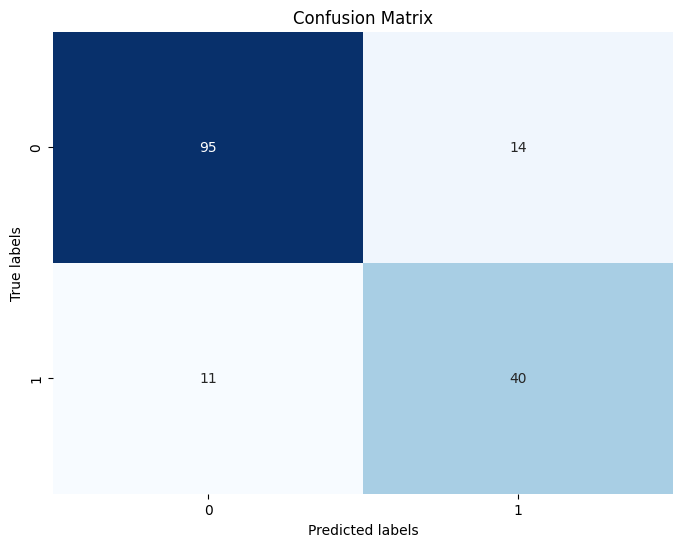

In [29]:
plot_confusion_matrix(labels_test, predictions)

In [30]:
del embedded_train_flat
del embedded_test_flat

In [31]:
df_test = pd.read_excel("/content/drive/MyDrive/Uni/Text Mining/test.xlsx")
df_test_reviews = pd.read_excel("/content/drive/MyDrive/Uni/Text Mining/test_reviews.xlsx")

In [32]:
test_df = pd.merge(df_test,df_test_reviews, on="index", how="left")

In [33]:
test_df

,index,description,host_about,comments
0,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de...",Thank you very much Antonio ! All has been per...
1,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de...",Very nice appartment in the old town of Lissab...
2,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de...",When travelling we're looking for kids friendl...
3,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de...",We've been in Lisbon in march 2013 (3 adults a...
4,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de...",Our host Antonio was very helpful with informa...
...,...,...,...,...
81311,1387,Beautiful and peaceful apartment with a superb...,"Nice, well travelled, educated, cult, cosmopol...",Excelente apartamento! Ótimo anfitrião! Aparta...
81312,1387,Beautiful and peaceful apartment with a superb...,"Nice, well travelled, educated, cult, cosmopol...","Nice apartment, spacius, well equipt and clean..."
81313,1388,The apartment in Lisbon has capacity for 2 pe...,We are Feels Like Home Holiday Rentals.\nA com...,Unfortunately not a pleasant experience. The h...
81314,1388,The apartment in Lisbon has capacity for 2 pe...,We are Feels Like Home Holiday Rentals.\nA com...,Hi everybody!<br/>If you want to live with coc...


In [34]:
    test_df = test_df.groupby('index').agg({
        'description': 'first',
        'host_about': 'first',
        'comments': lambda x: ' '.join(x.astype(str).values),
    }).reset_index()

In [35]:
test_df

,index,description,host_about,comments
0,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de...",Thank you very much Antonio ! All has been per...
1,2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...,"This is a beautiful, bright apartment in a mor..."
2,3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ...",nan
3,4,Charming Apartment Close to the Bay of Cascais...,:),Claudia was a great host. She met us at the t...
4,5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...,La maison est exactement comme sur les photos....
...,...,...,...,...
1384,1385,O melhor ponto de partida para descobrir Lisbo...,I work in Hospitality and I love traveling._x0...,nan
1385,1386,Casa de Baixo is a cozy and comfortable apartm...,"Visit us, stay with us and discover the most b...",Bonnes prestations et bien situé.<br/>Les doub...
1386,1387,Beautiful and peaceful apartment with a superb...,"Nice, well travelled, educated, cult, cosmopol...","Tiago é muito simpático e disponível, o aparta..."
1387,1388,The apartment in Lisbon has capacity for 2 pe...,We are Feels Like Home Holiday Rentals.\nA com...,Unfortunately not a pleasant experience. The h...


In [36]:
def predict_row(row):
    # Clean the text in the necessary columns
    cleaned_text = row[["description", "host_about", "comments"]].apply(clean_text)

    # Combine the necessary columns into a single text
    text_data = cleaned_text['description'] + ' ' + cleaned_text['host_about'] + ' ' + cleaned_text['comments']

    # Tokenize and convert the text data into sequences
    sequences = tokenizer.texts_to_sequences([text_data])

    # Pad the sequences to have the same length as the training data
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')

    # Create word embedding feature vectors
    embedded_data = np.array([embedding_matrix[word] for word in padded_sequences])
    embedded_data_flat = embedded_data.reshape(embedded_data.shape[0], -1)

    # Predict on the data
    prediction = classifier.predict(embedded_data_flat)

    return prediction[0]  # Assuming you want to return a single prediction

In [38]:
test_df['predictions'] = test_df.apply(lambda row: predict_row(row), axis=1)

In [39]:
test_df['predictions'].value_counts()

0    975
1    414
Name: predictions, dtype: int64

In [40]:
test_df.head()

,index,description,host_about,comments,predictions
0,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de...",Thank you very much Antonio ! All has been per...,0
1,2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...,"This is a beautiful, bright apartment in a mor...",0
2,3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ...",nan,1
3,4,Charming Apartment Close to the Bay of Cascais...,:),Claudia was a great host. She met us at the t...,0
4,5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...,La maison est exactement comme sur les photos....,0
